# Fake News Detection

In [1]:
from wordcloud import WordCloud
from argparse import Namespace
import collections
from collections import Counter
import json
import os
import re
import string
import os
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tqdm.notebook import tqdm

## Data Preparation & Analysis

In [2]:
# def truncate_text_by_word_count(text, max_words):
#     text = str(text)
#     words = text.split()
#     truncated_text = ' '.join(words[:max_words])
#     return str(truncated_text)

def dataset_with_splits(args):
    fake_news = pd.read_csv(args.fake_csv, header=0)
    fake_news['target'] = 'fake'
    true_news = pd.read_csv(args.true_csv, header=0)
    true_news['target'] = 'true'

    by_type = collections.defaultdict(list)
    for _, row in fake_news.iterrows():
        by_type[row.target].append(row.to_dict())
    for _, row in true_news.iterrows():
        by_type[row.target].append(row.to_dict())

    final_list = []
    np.random.seed(args.seed)
    for _, item_list in sorted(by_type.items()):
        np.random.shuffle(item_list)
        n = len(item_list)
        n_train = int(args.train_proportion*n)
        n_val = int(args.val_proportion*n)
        n_test = int(args.test_proportion*n)

        # Give data point a split attribute
        for item in item_list[:n_train]:
            item['split'] = 'train'
        for item in item_list[n_train:n_train+n_val]:
            item['split'] = 'val'
        for item in item_list[n_train+n_val:]:
            item['split'] = 'test'

        # Add to final list
        final_list.extend(item_list)

    final_news = pd.DataFrame(final_list)
    print(final_news.split.value_counts())

    final_news['text'] = final_news[args.text]

    final_news = final_news[['text', 'target', 'split']]

    final_news.to_csv(args.output_munged_csv, index=False)

    print(final_news.head())

In [3]:
datasets_args = Namespace(
    fake_csv = "/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv",
    true_csv = "/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv",
    train_proportion = 0.7,
    val_proportion = 0.15,
    test_proportion = 0.15,
    output_munged_csv = "datasets_with_splits.csv",
    seed = 2024,
    text = 'title',
)

dataset_with_splits(datasets_args)

df = pd.read_csv(datasets_args.output_munged_csv)

split
train    31427
test      6737
val       6734
Name: count, dtype: int64
                                                text target  split
0  WATCH: TREY GOWDY FURIOUS OVER LAWLESS Loretta...   fake  train
1   GOP Cut Funds For Veterans And Mental Health ...   fake  train
2   Breitbart Editor To CNN Host: A Song By Ringo...   fake  train
3   WATCH: Melania HUMILIATES Trump On World Stag...   fake  train
4   KKK Leader Threatens To ‘Burn’ A ‘N****r’ Jou...   fake  train


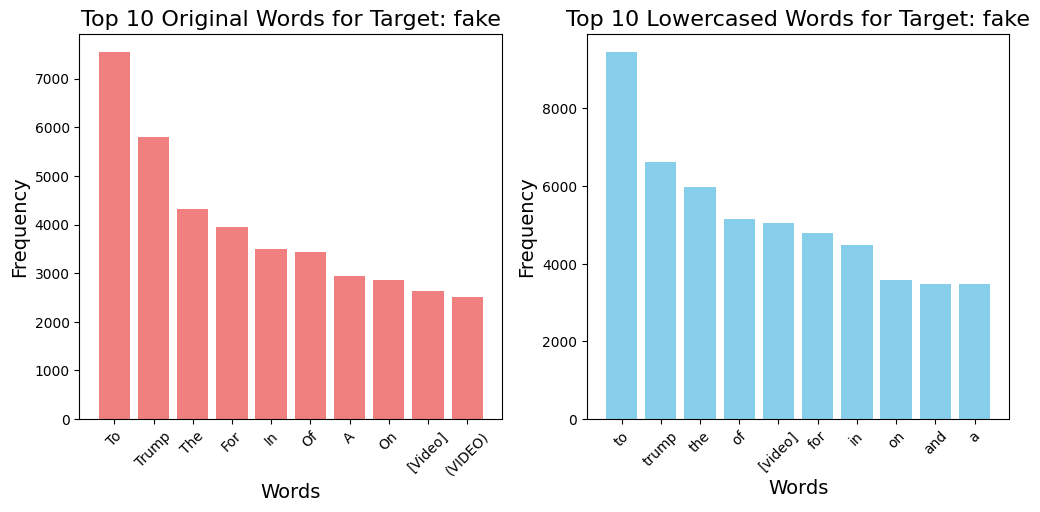

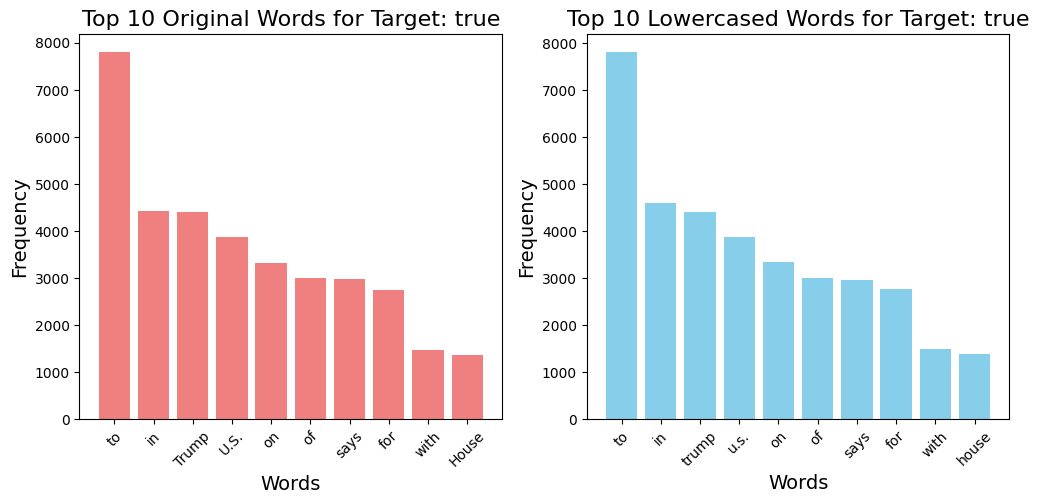

In [4]:
def plot_top_words_by_target(df):
    targets = df['target'].unique()

    for target in targets:
        titles = df[df['target'] == target]['text']

        original_text = ' '.join(titles)
        original_words = original_text.split()
        original_word_counts = Counter(original_words)
        original_top_words = original_word_counts.most_common(10)
        original_words, original_counts = zip(*original_top_words)

        lowercase_text = original_text.lower()
        lowercase_words = lowercase_text.split()
        lowercase_word_counts = Counter(lowercase_words)
        lowercase_top_words = lowercase_word_counts.most_common(10)
        lowercase_words, lowercase_counts = zip(*lowercase_top_words)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.bar(original_words, original_counts, color='lightcoral')
        plt.xlabel('Words', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Top 10 Original Words for Target: {target}', fontsize=16)
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.bar(lowercase_words, lowercase_counts, color='skyblue')
        plt.xlabel('Words', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Top 10 Lowercased Words for Target: {target}', fontsize=16)
        plt.xticks(rotation=45)
        plt.show()

plot_top_words_by_target(df)

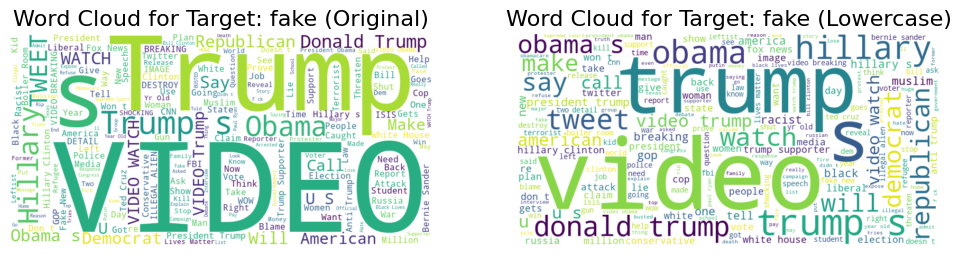

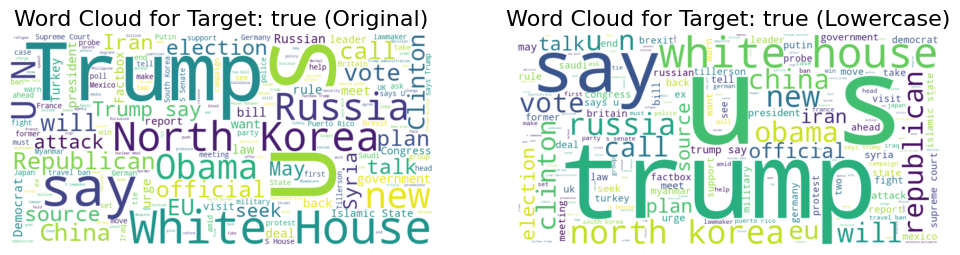

In [5]:
def plot_wordcloud(df):
    targets = df['target'].unique()

    for target in targets:
        text = ' '.join(df[df['target'] == target]['text'])

        original_wordcloud = WordCloud(width=800, height=400,
                                        background_color='white',
                                        colormap='viridis').generate(text)

        lowercase_text = text.lower()
        lowercase_wordcloud = WordCloud(width=800, height=400,
                                         background_color='white',
                                         colormap='viridis').generate(lowercase_text)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Target: {target} (Original)', fontsize=16)

        plt.subplot(1, 2, 2)
        plt.imshow(lowercase_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Target: {target} (Lowercase)', fontsize=16)
        plt.show()

plot_wordcloud(df)

## Vocabulary, Vectorizer, Dataset

In [6]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """
        # _token_to_idx for char_vocab:
        #   {'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'T': 4, 'o': 5, 't': 6, 'a': 7, ....., 'Á': 79}
        # _idx_to_token:
        #   {0:'<MASK>'0, 1:'<UNK>', 2:'<BEGIN>',   3:'<END>',   4:'T',  5:'o',  6:'t',  7:'a',....., 79:'Á'}

        # _token_to_idx nationality_vocab: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}
        # _idx_to_token:                   {0:'Arabic',  1:'Chinese', ...,  17:'Vietnamese'}

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """Retrieve the index associated with the token

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [7]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token  # for paddding, e.g., 'McMahan' -> [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)           # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)             # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token) # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)     # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [8]:
class TextVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, text_vocab, target_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.text_vocab = text_vocab
        self.target_vocab = target_vocab

    def vectorize(self, text, vector_length=-1):
        """
        Args:
            surname (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.text_vocab.begin_seq_index]
        indices.extend(self.text_vocab.lookup_token(token)
                       for token in text.split())
        indices.append(self.text_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)   # SurnameDataset._max_seq_length is 19 in current dataset.
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.text_vocab.mask_index

        """
        mask_index is 0
        unk_index is 1
        begin_seq_index is 2
        end_seq_index is 3

        When surname is "McMahan", M=5,c=6, a=7, h=8, and n=9

        out_vector = [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        len(indices) = 9
        """

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, text_df, cutoff=5):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        text_vocab = SequenceVocabulary() # add mask, unknown, begin_seq, and end_seq tokens to the token_to_index dictionary
        target_vocab = Vocabulary()

        for target in sorted(set(text_df.target)):
            target_vocab.add_token(target)

        word_counts = Counter()
        for text in text_df.text:
            for word in text.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1

        for word, count in word_counts.items():
            if count > cutoff:
                text_vocab.add_token(word)

        return cls(text_vocab, target_vocab)

## Model

In [9]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1   # deduct 1 since the index starts from 0
                                                              # e.g., [9, 6, 11, 9, 7, ...., 12]
    out = []
    for batch_index, column_index in enumerate(x_lengths): # out gets the last hidden vector of each input: (batch, hidden_size)
        out.append(y_out[batch_index, column_index]) # e.g., y_out[0, 9], y_out[1, 6]

    return torch.stack(out)  # (batch, hidden_size*num_directions); E.g., (64, 64*num_direction)

def column_summation(y_out, x_lengths, mode="mean"):
    '''Get a max or mean vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the max or mean vector of all the vectors by
    the position indicated by the corresponding value in `x_lengths` at the row index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)
        mode: "mean" for mean vector; "max" for max vector

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        if mode == "mean":
            mean_vector = y_out[batch_index, :column_index+1, :].mean(dim=0)
            out.append(mean_vector)
        else:
            max_vector, _ = y_out[batch_index, :column_index+1, :].max(dim=0)
            out.append(max_vector)

    return torch.stack(out)

class TextClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, bidirectional=False, batch_first=True, padding_idx=0, column_mode="default", is_attention=False):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector
                Note: the number of nationalities
            bidirectional (bool): Informs whether bidrectional RNN is used
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding;
                see torch.nn.Embedding
        """
        super(TextClassifier, self).__init__()

        self.column_mode = column_mode
        self.is_attention = is_attention

        if bidirectional == False:
             self.num_directions = 1
        else:
             self.num_directions = 2

        self.emb = nn.Embedding(num_embeddings=num_embeddings,    # E.g., (80, 100)
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)          # mask_index (padding index) is 0

        self.rnn = nn.RNN(input_size=embedding_size,              # E.g., 100
        #self.rnn = nn.GRU(input_size=embedding_size,
        #self.rnn = nn.LSTM(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,         # E.g., 64
                             batch_first=batch_first,
                             num_layers = 1,
                             dropout = 0.0,
                             bidirectional=bidirectional)

        self.fc1 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,  # 64*1 for unidirectinal; 64*2 for bidirectional
                         out_features=rnn_hidden_size*self.num_directions)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,
                          out_features=num_classes)                            # 18 classes
        # for batch norm
        self.bn1 = nn.BatchNorm1d(rnn_hidden_size*self.num_directions)

        # self.attention = nn.MultiheadAttention(embed_dim=rnn_hidden_size*self.num_directions, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=rnn_hidden_size*self.num_directions, num_heads=1, batch_first=True)


    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim, i.e. seq_size)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence: (batch,)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)      # (batch, seq_size)->(batch, seq_size, feat_size) ; E.g., (64,19)->(64,19,100)

        y_out, _ = self.rnn(x_embedded)  # (batch, seq_size, feat_size) -> (batch, seq_size, hidden_size*num_directions)
                                         # (64,19,100) -> (64,19,64*num_directions)

        # if x_lengths is not None:        # (batch, ) ; e.g., (64,) ; e.g., [9, 6, 11, 9, 7, ...., 12]
        #     if self.column_mode == "default":
        #         y_out = column_gather(y_out, x_lengths)
        #     elif self.column_mode == "mean":
        #         y_out = column_summation(y_out, x_lengths, mode="mean")
        #     elif self.column_mode == "max":
        #         y_out = column_summation(y_out, x_lengths, mode="max")

        if self.is_attention:
            attention_output, attn_output_weights = self.attention(y_out, y_out, y_out)  # 输出维度: [B, T, lstm_output_dim]
            y_out = attention_output[:, -1, :]
        else:
            y_out = column_gather(y_out, x_lengths)

        # with batch norm and dropout
        y_out = F.relu(self.bn1(self.fc1(F.dropout(y_out, 0.2, training=self.training))))  # y_out: (64, 64*num_direction)

        # with dropout
        y_out = self.fc2(F.dropout(y_out, 0.2, training=self.training))   # y_out: (batch, num_classes) ; (64, 18)

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [10]:
def preprocess_filter(text, stem=False):
    text = str(text).lower()

    return text

def longest_sentence_length(text):
    return len(text.split())

class TextDataset(Dataset):
    def __init__(self, text_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """

        self.text_df = text_df

        self._vectorizer = vectorizer

        self._max_seq_length = max(map(longest_sentence_length, self.text_df.text)) + 2   # add 2 for begin_seq_token and end_seq_token

        self.train_df = self.text_df[self.text_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.text_df[self.text_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.text_df[self.text_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # # Class weights
        # class_counts = self.train_df.nationality.value_counts().to_dict()   # {'English': 2972, 'Russian': 2373, ....}
        # def sort_key(item):
        #     return self._vectorizer.nationality_vocab.lookup_token(item[0]) # e.g, index of English is 4
        # sorted_counts = sorted(class_counts.items(), key=sort_key)          # sort by the index number of nationality_vocab
        #                            # {('Arabic', 1603), ('Chinese', 220), ('Czech', 414), ('Dutch', 236),('English', 2972), ...}
        # frequencies = [count for _, count in sorted_counts]
        # self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) # [1/1603, 1/220, 1/414, 1/236, 1/2972, ...]


    @classmethod
    def load_dataset_and_make_vectorizer(cls, text_csv, preprocess=False):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        text_df = pd.read_csv(text_csv)

        if preprocess:
            text_df['text'] = text_df['text'].apply(preprocess_filter)

        train_text_df = text_df[text_df.split=='train']
        return cls(text_df, TextVectorizer.from_dataframe(train_text_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]

        text_vector, vec_length = \
            self._vectorizer.vectorize(row.text, self._max_seq_length)

        target_index = \
            self._vectorizer.target_vocab.lookup_token(row.target)

        return {'x_data': text_vector,      # 'x_data': [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0],when surname is "McMahan"
                'y_target': target_index, # 'y_target': 4
                'x_length': vec_length}        # 'x_length': 9

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Preparation

### Training & Predict Function

In [11]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'test_prec': -1,
            'test_rec': -1,
            'test_f1': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        #if loss_t >= loss_tm1: # if current loss becomes smaller than the previous loss, early_stopping_step is reset to 0.
                                # this statement makes the model training time longer, compared to the statement below.
        if loss_t >= train_state['early_stopping_best_val']:  # curent loss is compared with early_stopping_best_val loss value
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices)

def compute_precision(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1].cpu().numpy()
    y_target = y_target.cpu().numpy()
    return precision_score(y_target, y_pred_indices, average='weighted', zero_division=0)

def compute_recall(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1].cpu().numpy()
    y_target = y_target.cpu().numpy()
    return recall_score(y_target, y_pred_indices, average='weighted', zero_division=0)

def compute_f1(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1].cpu().numpy()
    y_target = y_target.cpu().numpy()
    return f1_score(y_target, y_pred_indices, average='weighted', zero_division=0)

In [12]:
def training_loop(args, classifier, dataset):
    classifier = classifier.to(args.device)
    # dataset.class_weights = dataset.class_weights.to(args.device)

    # loss_func = nn.CrossEntropyLoss(dataset.class_weights)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10)

    train_state = make_train_state(args)

    epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    dataset.set_split('val')
    val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            batch_generator = generate_batches(dataset,
                                               batch_size=args.batch_size,
                                               device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. compute the output
                y_pred = classifier(x_in=batch_dict['x_data'],         # (batch, seq_size) ; e.g., (64,19)
                                    x_lengths=batch_dict['x_length'])  # (batch,) ; e.g, (64,)
                                                                       # y_pred: (batch, num_classes) ; e.g., (64,18)
                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])

                running_loss += (loss.item() - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on

            dataset.set_split('val')
            batch_generator = generate_batches(dataset,
                                               batch_size=args.batch_size,
                                               device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):
                # compute the output
                y_pred = classifier(x_in=batch_dict['x_data'],
                                    x_lengths=batch_dict['x_length'])

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                running_loss += (loss.item() - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                             train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            train_bar.n = 1
            val_bar.n = 1
            epoch_bar.update()

            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")

    return classifier, train_state

In [13]:
def model_predict(args, classifier, train_state, dataset):
    # compute the loss & accuracy on the test set using the best available model

    classifier.load_state_dict(torch.load(train_state['model_filename'],weights_only=False))

    classifier = classifier.to(args.device)
    # dataset.class_weights = dataset.class_weights.to(args.device)
    # loss_func = nn.CrossEntropyLoss(dataset.class_weights)
    loss_func = nn.CrossEntropyLoss()

    dataset.set_split('test')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    running_prec = 0.
    running_rec = 0.
    running_f1 = 0.
    classifier.eval()

    y_pred_list = []         # store predicted values for confusion matrix
    y_nationality_list = []  # ground truth value

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_data'],
                             x_lengths=batch_dict['x_length'])

        # store predicted values and ground truth values for calculating confusion matrix
        y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
        y_nationality_list.extend(batch_dict['y_target'].cpu().numpy())

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        # compute the precision
        prec_t = compute_precision(y_pred, batch_dict['y_target'])
        running_prec += (prec_t - running_prec) / (batch_index + 1)
        # compute the recall
        rec_t = compute_recall(y_pred, batch_dict['y_target'])
        running_rec += (rec_t - running_rec) / (batch_index + 1)
        # compute the f1 score
        # f1_t = f1_score(batch_dict['y_target'].cpu().numpy(), y_pred.max(dim=1)[1].cpu().numpy(), average='weighted')
        f1_t = compute_f1(y_pred, batch_dict['y_target'])
        running_f1 += (f1_t - running_f1) / (batch_index + 1)



    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    train_state['test_prec'] = running_prec
    train_state['test_rec'] = running_rec
    train_state['test_f1'] = running_f1

    return y_pred_list, y_nationality_list

### Plot Function

In [14]:
def plot_heatmap(input_size_list, hidden_size_list, train_state_list):
    test_loss_array = np.full((len(input_size_list), len(hidden_size_list)), np.nan, dtype=float)
    test_acc_array = np.full((len(input_size_list), len(hidden_size_list)), np.nan, dtype=float)
    test_f1_array = np.full((len(input_size_list), len(hidden_size_list)), np.nan, dtype=float)

    for (input_size, hidden_size), train_state in train_state_list.items():
        input_index = input_size_list.index(input_size)
        hidden_index = hidden_size_list.index(hidden_size)
        test_loss_array[input_index, hidden_index] = float(train_state['test_loss'])
        test_acc_array[input_index, hidden_index] = float(train_state['test_acc'])
        test_f1_array[input_index, hidden_index] = float(train_state['test_f1'])

    test_loss_results = pd.DataFrame(test_loss_array, index=input_size_list, columns=hidden_size_list)
    test_acc_results = pd.DataFrame(test_acc_array, index=input_size_list, columns=hidden_size_list)
    test_f1_results = pd.DataFrame(test_f1_array, index=input_size_list, columns=hidden_size_list)

    plt.figure(figsize=(8, 6))
    sns.heatmap(test_loss_results, annot=True, fmt=".5f", yticklabels=input_size_list, xticklabels=hidden_size_list, cmap='Greys')
    plt.xlabel('Input Size')
    plt.ylabel('Hidden Size')
    plt.title('Model Loss for Different Input and Hidden Sizes')
    plt.show()

    # plt.figure(figsize=(8, 6))
    # sns.heatmap(test_acc_results, annot=True, fmt=".5f", yticklabels=input_size_list, xticklabels=hidden_size_list, cmap='Greys')
    # plt.xlabel('Input Size')
    # plt.ylabel('Hidden Size')
    # plt.title('Model Accuracy for Different Input and Hidden Sizes')
    # plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(test_f1_results, annot=True, fmt=".5f", yticklabels=input_size_list, xticklabels=hidden_size_list, cmap='Greys')
    plt.xlabel('Input Size')
    plt.ylabel('Hidden Size')
    plt.title('Model F1 Score for Different Input and Hidden Sizes')
    plt.show()


In [15]:
# def plot_train_loss_acc(train_state, mode="default"):
#     acc = train_state['train_acc']
#     val_acc = train_state['val_acc']
#     loss = train_state['train_loss']
#     val_loss = train_state['val_loss']

#     epochs = range(1, len(acc) + 1)

#     plt.figure(figsize=(16, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, loss, 'bo', label='Training loss')
#     # b is for "solid blue line"
#     plt.plot(epochs, val_loss, 'b', label='Validation loss')
#     plt.title('{} mode: Training and validation loss'.format(mode))
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, acc, 'bo', label='Training acc')
#     plt.plot(epochs, val_acc, 'b', label='Validation acc')
#     plt.title('{} mode: Training and validation accuracy'.format(mode))
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.show()

In [16]:
def plot_confusion_matrix(y_pred_list, y_true_list):
    y_pred_array = np.array(y_pred_list)
    y_true_array = np.array(y_true_list)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true_array, y_pred_array)

    # Optional: Visualize the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_pred_array), yticklabels=np.unique(y_true_array))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_auc(y_pred_list, y_true_list):
    y_scores = np.array(y_pred_list)
    y_true_array = np.array(y_true_list)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true_array, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [17]:
def plot_parallel(data, metric):
    df = pd.DataFrame(data)

    labels = {col: col.replace('_', ' ').title() for col in df.columns}

    fig = px.parallel_coordinates(
        df,
        color=metric,
        labels=labels,
        color_continuous_scale=px.colors.sequential.Viridis
    )

    fig.show()

# data = {
#     'learning_rate': [0.001, 0.01, 0.1, 0.001, 0.01],
#     'batch_size': [32, 64, 32, 128, 32],
#     'num_layers': [3, 4, 5, 4, 3],
#     'dropout_rate': [0.2, 0.3, 0.1, 0.2, 0.5],
#     'f1_score': [0.888, 0.889, 0.878, 0.86, 0.80]
# }

# plot_parallel(data, metric='f1_score')

### Settings

In [18]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [19]:
def generate_args(model_state_file="model.pth",
                  input_size=100,
                  hidden_size=64,
                  num_epochs=100,
                  learning_rate=1e-3,
                  batch_size=64,
                  ):
    args = Namespace(
        datasets_csv=datasets_args.output_munged_csv,
        model_state_file=model_state_file,
        save_dir="/kaggle/working/models",

        char_embedding_size=input_size,
        rnn_hidden_size=hidden_size,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,

        seed=1337,
        early_stopping_criteria=5,
        bidirectional=False,

        cuda=True,
        catch_keyboard_interrupt=True,
        expand_filepaths_to_save_dir=True,
    )
    return args

def settings(args):
    # Check CUDA
    if not torch.cuda.is_available():
        args.cuda = False

    args.device = torch.device("cuda" if args.cuda else "cpu")

    print("Using CUDA: {}".format(args.cuda))


    if args.expand_filepaths_to_save_dir:
        args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

    # Set seed for reproducibility
    set_seed_everywhere(args.seed, args.cuda)

    # handle dirs
    handle_dirs(args.save_dir)


In [20]:
input_size_list = [50, 100, 200]
hidden_size_list = [64, 128, 512]
learning_rate_list = [1e-2, 2e-3, 1e-3]
batch_size_list = [64, 128, 256]

# input_size_list = [100]
# hidden_size_list = [512]
# learning_rate_list = [1e-2]
# batch_size_list = [256]

args_list = {}

for input_size in input_size_list:
    for hidden_size in hidden_size_list:
        for learning_rate in learning_rate_list:
            for batch_size in batch_size_list:
                args = generate_args(input_size=input_size,
                                    hidden_size=hidden_size,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size)
                args_list[(input_size, hidden_size, learning_rate, batch_size)] = args

## Experiment

### RNN Training & Analysis

In [21]:
rnn_train_state_list = {}
rnn_predict_list = {}

for values, args in args_list.items():
    model_state_file = "rnn_model_{}_{}_{}_{}.pth".format(values[0], values[1], values[2], values[3])
    args.model_state_file = model_state_file
    settings(args)

    dataset = TextDataset.load_dataset_and_make_vectorizer(args.datasets_csv)

    vectorizer = dataset.get_vectorizer()

    classifier = TextClassifier(embedding_size=args.char_embedding_size,
                                num_embeddings=len(vectorizer.text_vocab),
                                num_classes=len(vectorizer.target_vocab),
                                rnn_hidden_size=args.rnn_hidden_size,
                                padding_idx=vectorizer.text_vocab.mask_index,
                                bidirectional=args.bidirectional)

    classifier, train_state = training_loop(args, classifier, dataset)

    y_pred_list, y_true_list = model_predict(args, classifier, train_state, dataset)

    rnn_train_state_list[values] = train_state

    rnn_predict_list[values] = (y_pred_list, y_true_list)

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

In [22]:
rnn_data = {
    'input_size': [],
    'hidden_size': [],
    'learning_rate': [],
    'batch_size': [],
    'f1_score': [],
}
for (a, b, c, d), train_state in rnn_train_state_list.items():
    if (train_state['test_f1'] > 0.96):
        rnn_data['input_size'].append(a)
        rnn_data['hidden_size'].append(b)
        rnn_data['learning_rate'].append(c)
        rnn_data['batch_size'].append(d)
        rnn_data['f1_score'].append(train_state['test_f1'])

# plot_heatmap(input_size_list, hidden_size_list, rnn_train_state_list)
plot_parallel(data=rnn_data, metric='f1_score')

In [23]:
for (a, b, c, d), (y_pred_list, y_true_list) in rnn_predict_list.items():
    print("Input Size={}, Hidden Size={}, Learning Rate={}, Batch_size={}".format(a, b, c, d))
    print(classification_report(y_true_list, y_pred_list, zero_division=0))
    print()

Input Size=50, Hidden Size=64, Learning Rate=0.01, Batch_size=64
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3513
           1       0.99      0.99      0.99      3207

    accuracy                           0.99      6720
   macro avg       0.99      0.99      0.99      6720
weighted avg       0.99      0.99      0.99      6720


Input Size=50, Hidden Size=64, Learning Rate=0.01, Batch_size=128
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3480
           1       0.99      1.00      0.99      3176

    accuracy                           0.99      6656
   macro avg       0.99      0.99      0.99      6656
weighted avg       0.99      0.99      0.99      6656


Input Size=50, Hidden Size=64, Learning Rate=0.01, Batch_size=256
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3479
           1       1.00      0.99     

Input Size=100, Hidden Size=128, Learning Rate=0.01, Batch Size=256
Best F1 Score:0.9957937410965204
Accuracy: 0.9957932692307693
Precision: 0.9958409222531678
Recall: 0.9957932692307693


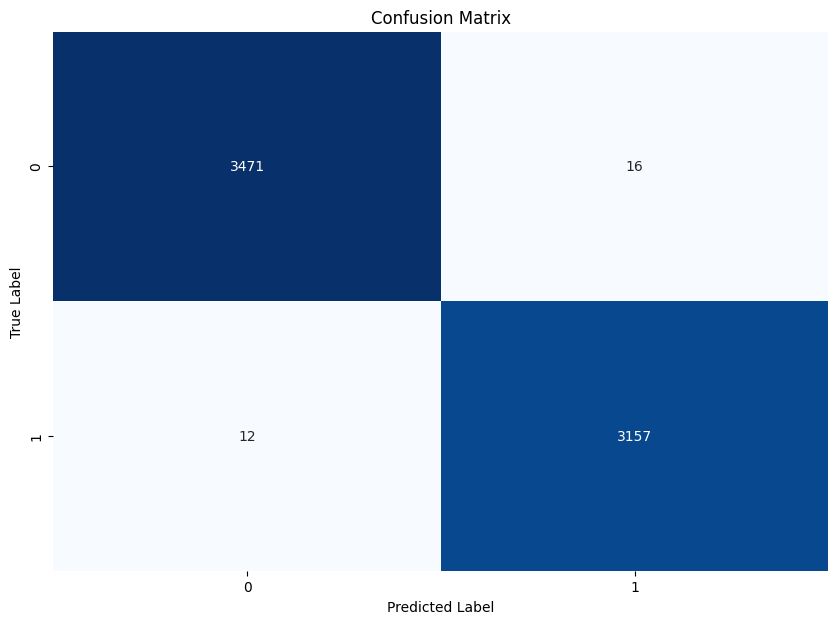

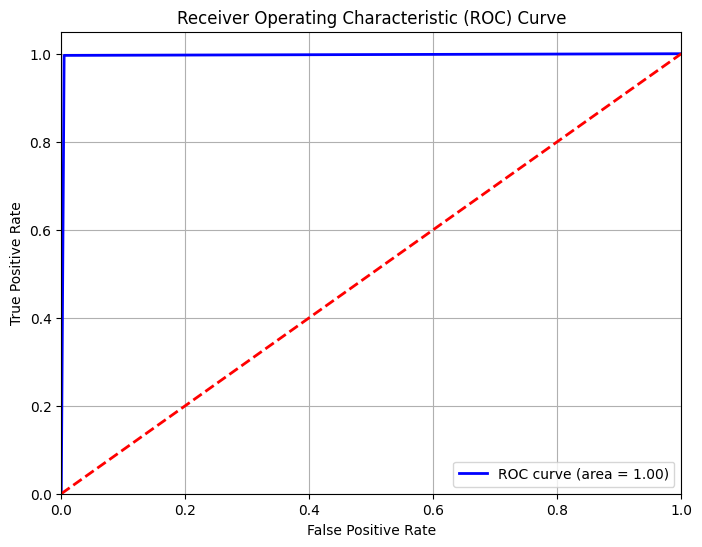

In [24]:
rnn_best_values = ()
rnn_best_f1_score = -1
rnn_acc = -1
rnn_prec = -1
rnn_rec = -1
for values, (y_pred_list, y_true_list) in rnn_predict_list.items():
    if rnn_train_state_list[values]['test_f1'] > rnn_best_f1_score:
        rnn_best_values = values
        rnn_best_f1_score = rnn_train_state_list[values]['test_f1']
        rnn_prec = rnn_train_state_list[values]['test_prec']
        rnn_rec = rnn_train_state_list[values]['test_rec']
        rnn_acc = rnn_train_state_list[values]['test_acc']

rnn_y_p_list, rnn_y_t_list = rnn_predict_list[rnn_best_values]

print(f"Input Size={rnn_best_values[0]}, Hidden Size={rnn_best_values[1]}, Learning Rate={rnn_best_values[2]}, Batch Size={rnn_best_values[3]}")
print(f"Best F1 Score:{rnn_best_f1_score}")
print(f"Accuracy: {rnn_acc}\nPrecision: {rnn_prec}\nRecall: {rnn_rec}")
plot_confusion_matrix(rnn_y_p_list, rnn_y_t_list)
plot_roc_auc(rnn_y_p_list, rnn_y_t_list)

### RNN with Attention Training & Analysis

In [25]:
rnn_attn_train_state_list = {}
rnn_attn_predict_list = {}

for values, args in args_list.items():
    model_state_file = "rnn_attn_model_{}_{}_{}_{}.pth".format(values[0], values[1], values[2], values[3])
    args.model_state_file = model_state_file
    settings(args)

    dataset = TextDataset.load_dataset_and_make_vectorizer(args.datasets_csv)

    vectorizer = dataset.get_vectorizer()

    classifier = TextClassifier(embedding_size=args.char_embedding_size,
                                   num_embeddings=len(vectorizer.text_vocab),
                                   num_classes=len(vectorizer.target_vocab),
                                   rnn_hidden_size=args.rnn_hidden_size,
                                   padding_idx=vectorizer.text_vocab.mask_index,
                                   bidirectional=args.bidirectional,
                                   is_attention=True)

    classifier, train_state = training_loop(args, classifier, dataset)

    y_pred_list, y_true_list = model_predict(args, classifier, train_state, dataset)

    rnn_attn_train_state_list[values] = train_state

    rnn_attn_predict_list[values] = (y_pred_list, y_true_list)

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/245 [00:00<?, ?it/s]

split=val:   0%|          | 0/52 [00:00<?, ?it/s]

Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/26 [00:00<?, ?it/s]

In [26]:
rnn_attn_data = {
    'input_size': [],
    'hidden_size': [],
    'learning_rate': [],
    'batch_size': [],
    'f1_score': [],
}
for (a, b, c, d), train_state in rnn_attn_train_state_list.items():
    if (train_state['test_f1'] > 0.96):
        rnn_attn_data['input_size'].append(a)
        rnn_attn_data['hidden_size'].append(b)
        rnn_attn_data['learning_rate'].append(c)
        rnn_attn_data['batch_size'].append(d)
        rnn_attn_data['f1_score'].append(train_state['test_f1'])

# plot_heatmap(input_size_list, hidden_size_list, rnn_attn_train_state_list)
plot_parallel(data=rnn_attn_data, metric='f1_score')

In [27]:
for (a,b,c,d), (y_pred_list, y_true_list) in rnn_attn_predict_list.items():
    print("Input Size={}, Hidden Size={}, Learning Rate={}, Batch_size={}".format(a, b, c, d))
    print(classification_report(y_true_list, y_pred_list, zero_division=0))
    print()

Input Size=50, Hidden Size=64, Learning Rate=0.01, Batch_size=64
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3514
           1       0.99      0.99      0.99      3206

    accuracy                           0.99      6720
   macro avg       0.99      0.99      0.99      6720
weighted avg       0.99      0.99      0.99      6720


Input Size=50, Hidden Size=64, Learning Rate=0.01, Batch_size=128
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3479
           1       0.99      1.00      0.99      3177

    accuracy                           0.99      6656
   macro avg       0.99      0.99      0.99      6656
weighted avg       0.99      0.99      0.99      6656


Input Size=50, Hidden Size=64, Learning Rate=0.01, Batch_size=256
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3476
           1       0.99      1.00     

Input Size=200, Hidden Size=64, Learning Rate=0.002, Batch Size=64
Best F1 Score:0.9964308577834919
Accuracy: 0.9964285714285717
Precision: 0.9965452577282261
Recall: 0.9964285714285717


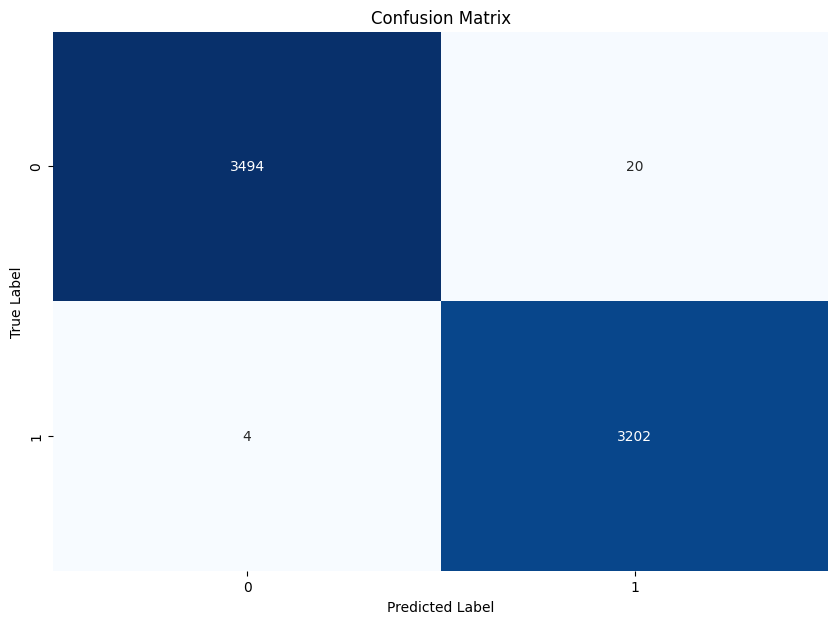

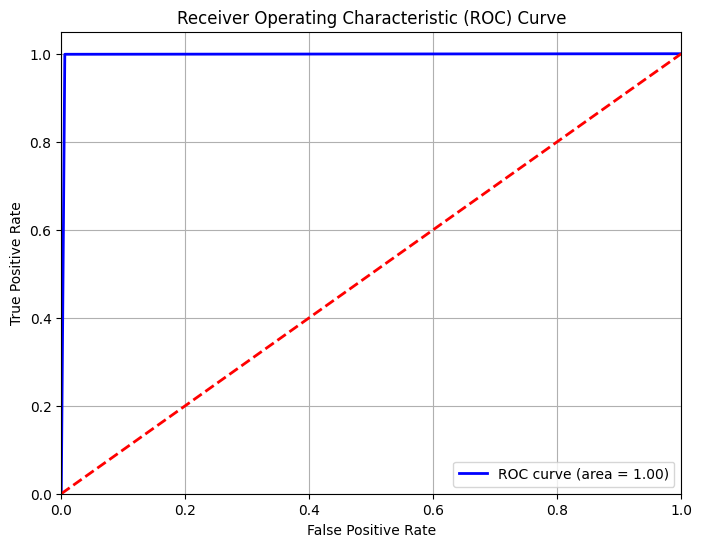

In [28]:
rnn_attn_best_values = ()
rnn_attn_best_f1_score = -1
rnn_attn_acc = -1
rnn_attn_prec = -1
rnn_attn_rec = -1
for values, (y_pred_list, y_true_list) in rnn_attn_predict_list.items():
    if rnn_attn_train_state_list[values]['test_f1'] > rnn_attn_best_f1_score:
        rnn_attn_best_values = values
        rnn_attn_best_f1_score = rnn_attn_train_state_list[values]['test_f1']
        rnn_attn_prec = rnn_attn_train_state_list[values]['test_prec']
        rnn_attn_rec = rnn_attn_train_state_list[values]['test_rec']
        rnn_attn_acc = rnn_attn_train_state_list[values]['test_acc']

rnn_attn_y_p_list, rnn_attn_y_t_list = rnn_attn_predict_list[rnn_attn_best_values]

print(f"Input Size={rnn_attn_best_values[0]}, Hidden Size={rnn_attn_best_values[1]}, Learning Rate={rnn_attn_best_values[2]}, Batch Size={rnn_attn_best_values[3]}")
print(f"Best F1 Score:{rnn_attn_best_f1_score}")
print(f"Accuracy: {rnn_attn_acc}\nPrecision: {rnn_attn_prec}\nRecall: {rnn_attn_rec}")
plot_confusion_matrix(rnn_attn_y_p_list, rnn_attn_y_t_list)
plot_roc_auc(rnn_attn_y_p_list, rnn_attn_y_t_list)

In [29]:
dataset = TextDataset.load_dataset_and_make_vectorizer(args.datasets_csv)

vectorizer = dataset.get_vectorizer()

In [30]:
vectorizer.text_vocab._token_to_idx

{'<MASK>': 0,
 '<UNK>': 1,
 '<BEGIN>': 2,
 '<END>': 3,
 'WATCH:': 4,
 'TREY': 5,
 'GOWDY': 6,
 'FURIOUS': 7,
 'OVER': 8,
 'Loretta': 9,
 'Lynch': 10,
 'During': 11,
 'Clinton': 12,
 'Email': 13,
 '“It': 14,
 'was': 15,
 'a': 16,
 'total': 17,
 'WASTE': 18,
 'of': 19,
 'facts': 20,
 'are': 21,
 'for': 22,
 'her': 23,
 'presidential': 24,
 'candidate': 25,
 'GOP': 26,
 'Cut': 27,
 'Funds': 28,
 'For': 29,
 'Veterans': 30,
 'And': 31,
 'Mental': 32,
 'Health': 33,
 'Now': 34,
 'We': 35,
 'Have': 36,
 'A': 37,
 'Veteran': 38,
 'Suicide': 39,
 'Breitbart': 40,
 'Editor': 41,
 'To': 42,
 'CNN': 43,
 'Song': 44,
 'By': 45,
 'Proves': 46,
 'Roy': 47,
 'Moore': 48,
 'Isn’t': 49,
 '(VIDEO)': 50,
 'Melania': 51,
 'HUMILIATES': 52,
 'Trump': 53,
 'On': 54,
 'World': 55,
 'Stage': 56,
 'With': 57,
 'Obvious': 58,
 'Display': 59,
 'Of': 60,
 'KKK': 61,
 'Leader': 62,
 'Threatens': 63,
 'Journalist': 64,
 'Interview': 65,
 'Nancy': 66,
 'Pelosi': 67,
 'Backs': 68,
 'BOMBSHELL': 69,
 'Legislation': 70

In [31]:
dataset._max_seq_length

44